# ** ==================== { 更新第三方库 } ====================**

*   colab 需要更新一下 albumentations



In [1]:
#### 
#!pip install albumentations==0.4.6

     |████████████████████████████████| 117 kB 5.3 MB/s 
     |████████████████████████████████| 948 kB 31.4 MB/s 
  Created wheel for albumentations: filename=albumentations-0.4.6-py3-none-any.whl size=65172 sha256=56cae24bd3c49e912951de317ee0424d0b01875cadeae6653d4fcc9755655e60
  Stored in directory: /root/.cache/pip/wheels/cf/34/0f/cb2a5f93561a181a4bcc84847ad6aaceea8b5a3127469616cc
Successfully built albumentations
  Attempting uninstall: imgaug
    Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Attempting uninstall: albumentations
    Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


# ** ==================== { 查看GPU信息 } ====================**

In [2]:
#!nvidia-smi

Mon Nov 29 06:32:44 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P8    30W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# ** ==================== { 装载谷歌云盘 } ====================**

*   将输出保存至云盘，colab不能保存文件



In [3]:
#from google.colab import drive
#drive.mount('/content/drive')

Mounted at /content/drive


# ** ==================== { 导入第三方库 } ====================**

In [25]:
## 在console中输出图像
%matplotlib inline

## 数据预处理 Preprocessing
import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import StratifiedKFold
from torch.utils.data import Dataset, DataLoader
import torchvision
import cv2

## 数据增强 Augmentation
import albumentations
from albumentations.pytorch.transforms import ToTensorV2

## 神经网络 Net
import torch
import torchvision
from torch import nn

## 多线程checkpoint
import threading

## 作图
import matplotlib.pyplot as plt

## 评估指标
from sklearn.metrics import classification_report

# ** ==================== { 定义存储类 } ====================**

In [2]:
#### 定义一个保存历史数据的类
class history:
    def __init__(self):
        self.data = []
    def add(self, *args):
        self.data.append(args)
    def reset(self):
        self.data = []
    def __getitem__(self, idx):
        return self.data[idx]
    def load(self, form = 'csv'):
        return(pd.DataFrame(self.data))

In [3]:
#### 定义一个累积求和的类（方便在每个epoch累积求和batch的结果）
class Accumulator:
    def __init__(self, n):
        self.data = [0] * n
    def reset(self):
        self.data = [0] * len(self.data)
    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]
    def __getitem__(self, idx):
        return self.data[idx]

In [4]:
#### 定义用来保存模型和输出结果的线程类
class SaveThread(threading.Thread):
    def __init__(self, state_dict, history, k, epoch, acc):
        threading.Thread.__init__(self)
        self.state_dict = state_dict
        self.file = params['save_path']
        self.history = history
        self.k = k
        self.epoch = epoch
        self.acc = acc
        
    def run(self):
        torch.save(self.state_dict, os.path.join(self.file, f'check_point/k_{self.k}-epoch_{self.epoch}-acc_{self.acc}.params') )
        self.history.to_csv(os.path.join(self.file, f'check_point/history.csv'), index = None)
        print(f'check_point in k {self.k}, epoch {self.epoch}: Done')

In [5]:
## 定义数据集类
class hot_dog_dataset(Dataset):
    def __init__(self, images_filepaths, labels, transform = None):
        # 数据集的图片路径集合
        self.images_filepaths = images_filepaths
        # 数据集的labels
        self.labels = labels
        # 数据集的转换方法
        self.transform = transform
    
    def __len__(self):
        # 返回数据集样本数
        return len(self.images_filepaths)
    
    def __getitem__(self, idx):
        # 获取第 idx 的图片路径
        image_filepath = self.images_filepaths[idx]
        # 读取第 idx 的图片路径
        image = cv2.imread(image_filepath)
        # 转换第 idx 的图片为 RGB格式
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
          
        # 获取第 idx 的图片 label
        label = self.labels[idx]
        if self.transform is not None:
            # 获取转换后的数据
            image = self.transform(image = image)['image']
        return image, label

# ** ==================== { 导入函数方法 } ====================**

In [6]:
## 定义数据转换（包括数据增广）方法
# 定义训练数据转换方法
def get_train_trans():
    return albumentations.Compose(
            [
                # 缩放为 320 * 320 像素
                albumentations.Resize(320, 320),
                # 随机0.5概率垂直翻转
                albumentations.HorizontalFlip(p = 0.5),
                # 随机0.5概率水平翻转
                albumentations.VerticalFlip(p = 0.5),
                # 随机0.7概率旋转，最高180度
                albumentations.Rotate(limit = 180, p = 0.7),
                # 随机亮度对比度
                albumentations.RandomBrightnessContrast(),
                # 平移缩放旋转
                albumentations.ShiftScaleRotate(
                    shift_limit = 0.25, scale_limit = 0.1, rotate_limit = 0),
                # 归一化（imagenet的均值与方差）
                albumentations.Normalize(
                    [0.485, 0.456, 0.406], [0.229, 0.224, 0.225],
                    max_pixel_value = 225.0, always_apply = True),
                # 转换为tensor数据格式,V2 适合跟在normalize后面
                ToTensorV2()
            ]
    )

#定义测试数据转换方法
def get_test_trans():
    return albumentations.Compose(
            [
                # 缩放为 320 * 320 像素
                albumentations.Resize(320, 320),
                # 归一化（imagenet的均值与方差）
                albumentations.Normalize(
                    [0.485, 0.456, 0.406], [0.229, 0.224, 0.225],
                    max_pixel_value = 225.0, always_apply = True),
                # 转换为tensor数据格式,V2 适合跟在normalize后面
                ToTensorV2()
            ]
    )

In [7]:
#### 获取GPU设备
def try_gpu(i = 0):
    if torch.cuda.device_count() >= i + 1:
        return torch.device(f'cuda:{i}')
    return torch.device('cpu')

In [8]:
#### 定义准确率方法
def accuracy(y_hat, y):
    y_hat = y_hat.argmax(axis = 1)
    cmp = y_hat == y
    return cmp.sum()

In [9]:
#### 定义每个epoch的训练方法
def train_epoch(net, train_iter, loss, optimizer, params):
    # 开启模型的训练模式
    if isinstance(net, nn.Module):
        net.train()
    # 定义累积求和的存储对象
    metrics = Accumulator(3)
    for X, y in train_iter:
        # 将数据 X，y 移到定义的设备上
        X, y = X.to(params['device']), y.to(params['device'])
        # 清空权重的梯度
        optimizer.zero_grad()
        # 获取预测值
        y_hat = net(X)
        # 求得损失
        l = loss(y_hat, y.long())
        # 对损失函数自动求导
        l.backward()
        # 根据损失对权重的求导结果来更新权重
        optimizer.step()
        # 将结果存入累计求和的存储器
        metrics.add(float(l) * len(y), accuracy(y_hat, y), y.size().numel())
    return metrics[0] / metrics[2], metrics[1] / metrics[2]

In [10]:
#### 定义每个epoch的评估方法
def evaluate_epoch(net, data_iter, loss, params):
    # 开启模型的评估模式
    if isinstance(net, nn.Module):
        net.eval()
    # 定义累计求和的存储对象
    metrics = Accumulator(3)
    for X, y in data_iter:
        # 将数据 X，y 移到定义的设备上
        X, y = X.to(params['device']), y.to(params['device'])
        # 获取预测值
        y_hat = net(X)
        # 求得损失
        l = loss(y_hat, y.long())
        # 将结果存入累计求和的存储器
        metrics.add(float(l) * len(y), accuracy(y_hat, y), y.size().numel())
    return metrics[0] / metrics[2], metrics[1] / metrics[2]

In [11]:
#### 定义模型的训练过程
def train(net, datasets, params, k, param_group = True):
    # 将网络模型存入定义的设备中
    net.to(params['device'])
    # 获取训练数据的迭代器
    train_iter = DataLoader(datasets['train'], batch_size = params['batch_size'],
                           shuffle = True, num_workers = params['num_workers'])
    # 获取测试数据的迭代器（验证集）
    test_iter = DataLoader(datasets['test'], batch_size = params['batch_size'],
                          shuffle = False, num_workers = params['num_workers'])
    # 定义损失函数
    loss = nn.CrossEntropyLoss()
    # 将新加入层的学习率调高十倍
    if param_group:
        params_1x = [
            param for name, param in net.named_parameters()
            if name not in ['fc.weight', 'fc.bias']
        ]
        optimizer = torch.optim.AdamW([
            {'params': params_1x}, 
            {'params':net.fc.parameters(), 'lr': params['lr'] * 10}],
             lr=params['lr'], weight_decay = params['weight_decay'])
    # 不对新加入层的学习率进行调整
    else:
        optimizer = torch.optim.SGD(net.parameters(), lr = params['lr'],
                                   weight_decay = params['weight_decay'])
    
    # 开始每个epoch的训练
    for epoch in range(params['num_epochs']):
        # 获取单个epoch的训练结果
        train_metrics = train_epoch(net, train_iter, loss, optimizer, params)
        # 获取单个epoch的测试结果（验证集）
        test_metrics = evaluate_epoch(net, test_iter, loss, params)
        # 打印输出结果
        print(f'epoch {epoch}: train loss = {train_metrics[0]:f}, train acc = {train_metrics[1]:f}, test loss = {test_metrics[0]:f}, test acc = {test_metrics[1]:f},')
        # 将结果存入历史数据存储对象
        params['history_data'].add(
            k, epoch + 1, round(train_metrics[0], 4), round(train_metrics[1], 4), round(test_metrics[0], 4), round(test_metrics[1], 4)
        )
        # 增加断点保存功能（每 n 个epoch存储一次模型）
        if epoch % params['check_epochs'] == 0 or epoch == params['num_epochs'] - 1:
          # 加载历史数据
          his = params['history_data'].load()
          # 获取模型参数
          state_dict = net.state_dict()
          # 对历史数据与模型参数进行保存（调用线程）
          save_thread = SaveThread(state_dict, his, k, epoch, round(test_metrics[1], 4))
          # 将线程保存（方便在最后设置等待所有线程结束再退出）
          params['save_threads'].append(save_thread)
          # 开始运行线程
          save_thread.start()
        

In [12]:
def predict(net, test_df, prob = True):
    net.eval()
    test_img = test_df['img']
    test_labels = test_df['label']
    
    test_dataset = hot_dog_dataset(
                test_img.values, test_labels.values, transform = get_test_trans())
    
    test_iter = DataLoader(test_dataset, batch_size = params['batch_size'],
                          shuffle = False, num_workers = params['num_workers'])
    
    if prob:
        labels = torch.randn((params['batch_size'], params['classes'])).numpy()
    else:
        labels = []
    with torch.no_grad():
        for X, y in test_iter:
            y_hat = net(X)
            if prob:
                y_hat = y_hat.detach().numpy()
                labels = np.append(labels, y_hat, axis = 0)
            else:
                y_hat = y_hat.argmax(axis = 1)
                [labels.append(int(i)) for i in y_hat]
        if prob:
            labels = labels[params['batch_size']:]
    return labels

In [13]:
def show_wrong_imgs(data_df, n, num_rows, num_cols, scale = 3,
                   col_img = 'img', col_label = 'label', col_pred = 'pred'
                  ):
    imgs = test_df[test_df['label'] != test_df['pred']]
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = plt.subplots(num_rows, num_cols, figsize = figsize)
    axes = axes.flatten()
    for i, (ax, img) in enumerate(zip(axes, imgs['img'])):
        if i > n:
            break
        img = cv2.imread(img)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        ax.imshow(img)
        ax.set_title(f'true = {label_map[imgs["label"].iloc[i]]}\npred = {label_map[imgs["pred"].iloc[i]]}')
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)

# ** ==================== { 数据获取与参数定义 } ====================**

In [16]:
# #### 将数据整理成csv文件（只需运行一遍）
# path = './drive/MyDrive/data/hotdog'

# train_path = os.path.join(path, 'train')
# test_path = os.path.join(path, 'test')
# train_1 = [[os.path.join(train_path , 'hotdog',i) , 'hotdog']
#              for i in os.listdir(os.path.join(train_path, 'hotdog'))
#           ]
# train_0 = [[os.path.join(train_path , 'not-hotdog',i), 'not-hotdog'] 
#              for i in os.listdir(os.path.join(train_path, 'not-hotdog'))
#           ]
# test_1 = [[os.path.join(test_path , 'hotdog',i) , 'hotdog']
#              for i in os.listdir(os.path.join(test_path, 'hotdog'))
#           ]
# test_0 = [[os.path.join(test_path , 'not-hotdog',i), 'not-hotdog'] 
#              for i in os.listdir(os.path.join(test_path, 'not-hotdog'))
#           ]

# # 保存csv文件
# train_data = pd.DataFrame(train_1 + train_0, columns = ['img', 'label'])
# test_data = pd.DataFrame(test_1 + test_0, columns = ['img', 'label'])
# train_data.to_csv(os.path.join(path, 'train.csv'), index = None)
# test_data.to_csv(os.path.join(path, 'test.csv'), index = None)  


In [14]:
#### 固定随机种子
seed = 622
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True

In [15]:
#### 定义参数
params = {
    #'model': net,
    'classes': 2,
    # 运行设备
    'device': try_gpu(),
    'k': 5,
    'lr': 5e-5,
    'batch_size': 64,
    # 读取数据的线程数
    'num_workers': 0,
    'num_epochs': 50,
    'weight_decay': 1e-5,
    'history_data': history(),
    'save_path': './drive/MyDrive/data/hotdog',
    'save_threads': [],
    'check_epochs': 5
}


In [16]:
#### 获取数据
# 获取训练集和测试集的数据路径
train_path = os.path.join(params['save_path'], 'train.csv')
test_path = os.path.join(params['save_path'], 'test.csv')

# 读取图片路径数据
train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

# 获取所有类别值
classes = train_df['label'].unique()

# 定义label编码器
le = LabelEncoder()
le.fit(train_df['label'])

# 对训练集和测试集的label进行编码
train_df['label'] = le.transform(train_df['label'])
test_df['label'] = le.transform(test_df['label'])

# 获取编码器的对应关系
label_map = dict(zip(le.transform(le.classes_), le.classes_))

# ** ==================== { 模型训练 } ====================**

In [ ]:
#### k折交叉训练
# 定义进行k折交叉的对象
kf = StratifiedKFold(n_splits=params['k'], shuffle=True, random_state=seed)

# k折交叉训练
for k, (train_index,valid_index) in enumerate(kf.split(train_df['img'], train_df['label'])):
    # 获取拆分后的训练集与验证集
    train_img, valid_img = train_df['img'][train_index], train_df['img'][valid_index]
    train_labels, valid_labels = train_df['label'][train_index], train_df['label'][valid_index]
    
    # 定义训练集和验证集的数据存储对象（方便进行按batch读取）
    train_dataset = hot_dog_dataset(
                train_img.values, train_labels.values, transform = get_train_trans())
    test_dataset = hot_dog_dataset(
                valid_img.values, valid_labels.values, transform = get_test_trans())
    datasets = {'train': train_dataset, 'test': test_dataset}
    
    # 定义预训练模型
    finetune_net = torchvision.models.resnet18(pretrained = True)
    # 改变预训练模型的最后一层
    finetune_net.fc = nn.Linear(finetune_net.fc.in_features, params['classes'])
    # 初始化最后一层的参数
    nn.init.xavier_uniform_(finetune_net.fc.weight)
    
    # 开始训练
    train(finetune_net, datasets, params, k)

# 等待所有存储线程结束
[t.join() for t in params['save_threads']]
params['save_threads'] = []

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

epoch 0: train loss = 0.305399, train acc = 0.870459, test loss = 0.119601, test acc = 0.952199,
check_point in k 0, epoch 0: Done
epoch 1: train loss = 0.134850, train acc = 0.950287, test loss = 0.089302, test acc = 0.969407,
epoch 2: train loss = 0.094807, train acc = 0.965583, test loss = 0.067561, test acc = 0.969407,
epoch 3: train loss = 0.078374, train acc = 0.974187, test loss = 0.055070, test acc = 0.975143,
epoch 4: train loss = 0.061615, train acc = 0.977533, test loss = 0.037723, test acc = 0.986616,
epoch 5: train loss = 0.052265, train acc = 0.981836, test loss = 0.046004, test acc = 0.977055,
check_point in k 0, epoch 5: Done
epoch 6: train loss = 0.042247, train acc = 0.986616, test loss = 0.060759, test acc = 0.984704,
epoch 7: train loss = 0.033908, train acc = 0.990918, test loss = 0.055726, test acc = 0.975143,
epoch 8: train loss = 0.035457, train acc = 0.989006, test loss = 0.039755, test acc = 0.984704,
epoch 9: train loss = 0.035770, train acc = 0.988528, test 

In [17]:
#### 历史数据合并（断点合并）
history_data1 = pd.read_csv(os.path.join(params['save_path'], 'check_point/history.csv'))
history_data2 = pd.read_csv(os.path.join(params['save_path'], 'check_point/history (2).csv'))
history_data1 = history_data1.iloc[:-11]
history_data = pd.concat([history_data1, history_data2])
history_data.columns = ['k','epoch','train_loss','train_acc','test_loss','test_acc']
history_data = history_data.groupby('epoch').sum()/params['k']

Text(0.5, 0, 'epoch')

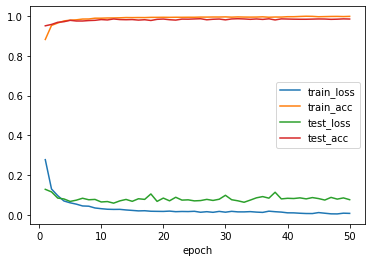

In [20]:
#### 打印图像
for col in history_data.columns[1:]:
    plt.plot(history_data[col][:50])
plt.legend(['train_loss','train_acc','test_loss','test_acc'])
plt.xlabel('epoch')

In [21]:
#### 获得每个 fold 准确率最高的模型（若出现相同准确率，为了更好的泛化性，选取epoch较小的）
model_path_list =[
    params['save_path'] + '/check_point/k_0-epoch_45-acc_0.9943.params',
    params['save_path'] + '/check_point/k_1-epoch_35-acc_0.9866.params',
    params['save_path'] + '/check_point/k_2-epoch_25-acc_0.9885.params',
    params['save_path'] + '/check_point/k_3-epoch_15-acc_0.9866.params',
    params['save_path'] + '/check_point/k_4-epoch_49-acc_0.9866.params'
] 

In [22]:
#### 用每个 fold 的最优模型进行预测，并进行平均合并
preds = []
for model_path in model_path_list:
    finetune_net = torchvision.models.resnet18(pretrained = True)
    finetune_net.fc = nn.Linear(finetune_net.fc.in_features, 2)
    finetune_net.load_state_dict(torch.load(model_path))
    labels = predict(finetune_net, test_df)
    preds.append(labels)

preds = np.array(preds).sum(axis=0) / len(model_path_list)

In [23]:
#### 得出预测结果，并输出预测错误的个数
test_df['pred'] = preds.argmax(axis = 1)
print('num_wrong_imgs: ', len(test_df['img'][test_df['label'] != test_df['pred']]))

num_wrong_imgs:  18


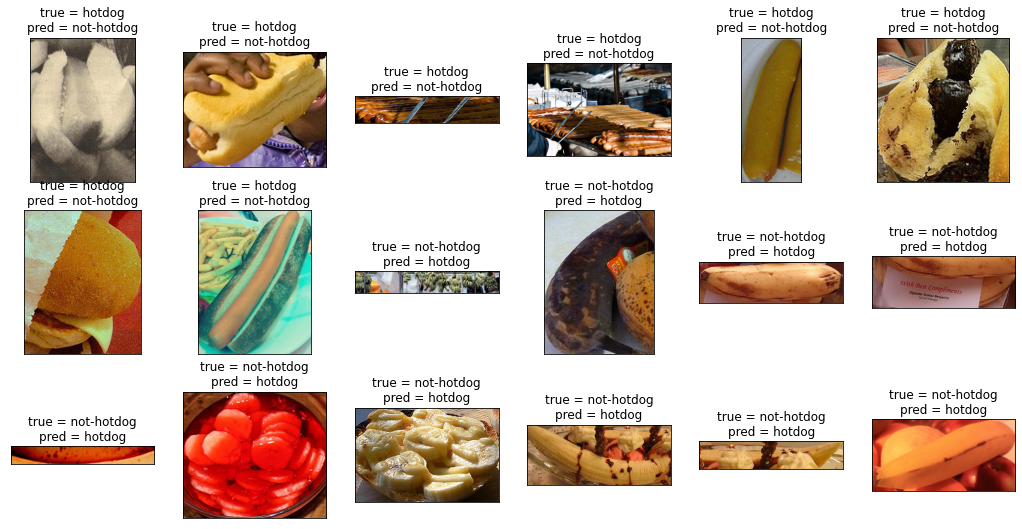

In [24]:
#### 打印预测出错的图片
show_wrong_imgs(test_df, 18, 3, 6)

In [26]:
## ========== 打印评价指标
indicators = classification_report(test_df['label'], preds.argmax(axis = 1), digits=4)
print(indicators)

              precision    recall  f1-score   support

           0     0.9751    0.9800    0.9776       400
           1     0.9799    0.9750    0.9774       400

    accuracy                         0.9775       800
   macro avg     0.9775    0.9775    0.9775       800
weighted avg     0.9775    0.9775    0.9775       800

